### Source Code
 - https://www.datascience.com/blog/fraud-detection-with-tensorflow
 
### Data
 - https://www.kaggle.com/mlg-ulb/creditcardfraud/data

In [5]:
# import packages
# matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.preprocessing import StandardScaler
from pylab import rcParams
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

#set random seed and percentage of test data
RANDOM_SEED = 314 #used to help randomly select the data points
TEST_PCT = 0.2 # 20% of the data

#set up graphic style in this case I am using the color scheme from xkcd.com
rcParams['figure.figsize'] = 14, 8.7 # Golden Mean
LABELS = ["Normal","Fraud"]
col_list = ["cerulean","scarlet"]# https://xkcd.com/color/rgb/
sns.set(style='white', font_scale=1.75)

In [6]:
df = pd.read_csv("../../../Documents/Data/creditcard.csv") #unzip and read in data downloaded to the local directory
df.head(n=5) #just to check you imported the dataset properly

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [7]:
df.shape #secondary check on the size of the dataframe

(284807, 31)

In [8]:
df.isnull().values.any() #check to see if any values are null, which there are not

False

284,315 normal transactions and 492 fraud transactions

In [9]:
pd.value_counts(df['Class'], sort = True) #class comparison 0=Normal 1=Fraud

0    284315
1       492
Name: Class, dtype: int64

In [10]:
normal_df = df[df.Class == 0] #save normal_df observations into a separate df
fraud_df = df[df.Class == 1] #do the same for frauds

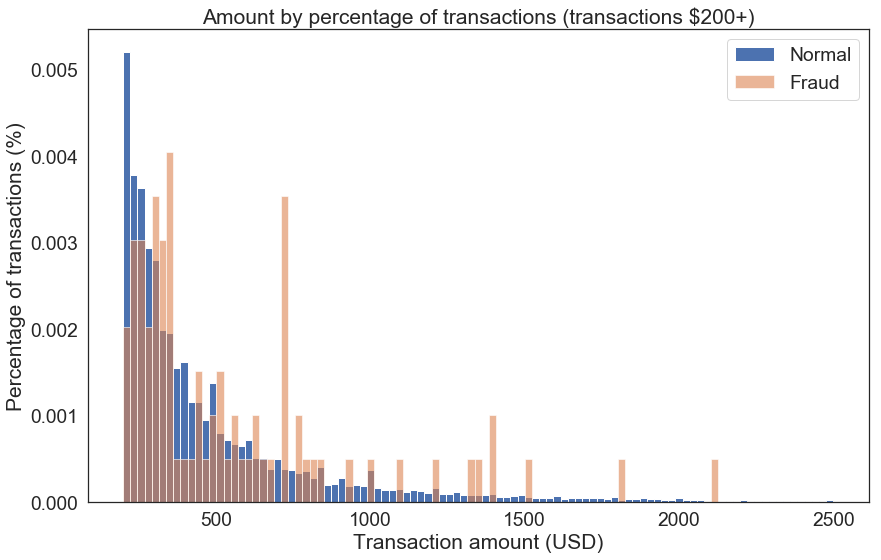

In [14]:
#plot of high value transactions
bins = np.linspace(200, 2500, 100)
plt.hist(normal_df.Amount, bins, alpha=1, density=True, label='Normal')
plt.hist(fraud_df.Amount, bins, alpha=0.6, density=True, label='Fraud')
plt.legend(loc='upper right')
plt.title("Amount by percentage of transactions (transactions \$200+)")
plt.xlabel("Transaction amount (USD)")
plt.ylabel("Percentage of transactions (%)");
plt.show()

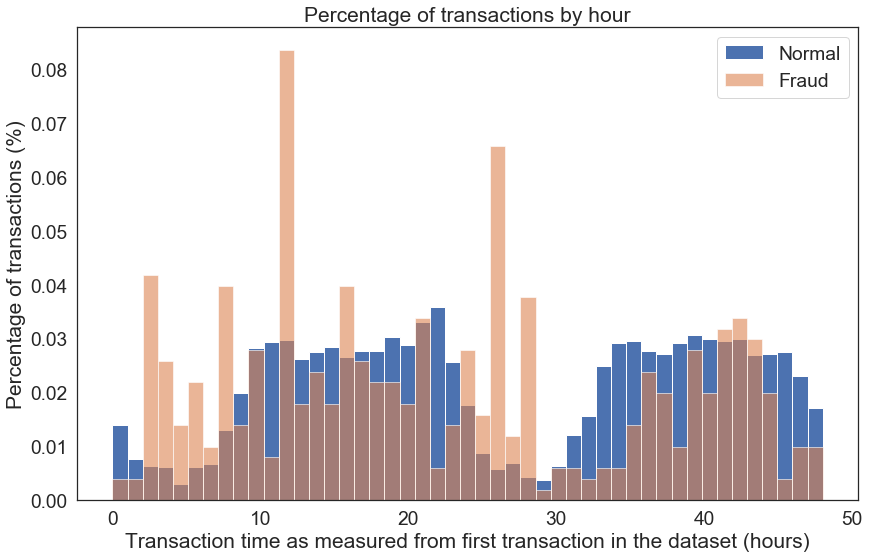

In [15]:
bins = np.linspace(0, 48, 48) #48 hours
plt.hist((normal_df.Time/(60*60)), bins, alpha=1, density=True, label='Normal')
plt.hist((fraud_df.Time/(60*60)), bins, alpha=0.6, density=True, label='Fraud')
plt.legend(loc='upper right')
plt.title("Percentage of transactions by hour")
plt.xlabel("Transaction time as measured from first transaction in the dataset (hours)")
plt.ylabel("Percentage of transactions (%)");
#plt.hist((df.Time/(60*60)),bins)
plt.show()

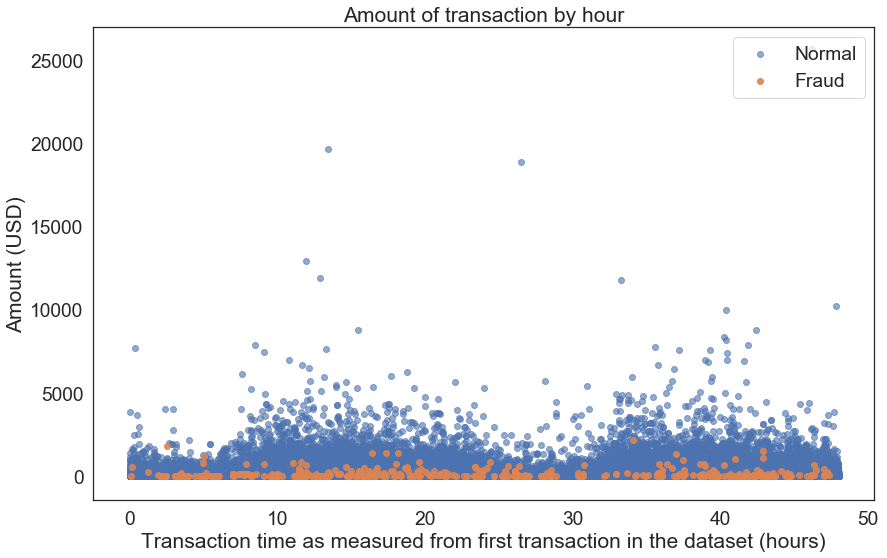

In [16]:
plt.scatter((normal_df.Time/(60*60)), normal_df.Amount, alpha=0.6, label='Normal')
plt.scatter((fraud_df.Time/(60*60)), fraud_df.Amount, alpha=0.9, label='Fraud')
plt.title("Amount of transaction by hour")
plt.xlabel("Transaction time as measured from first transaction in the dataset (hours)")
plt.ylabel('Amount (USD)')
plt.legend(loc='upper right')
plt.show()

In [17]:
df_norm = df
df_norm['Time'] = StandardScaler().fit_transform(df_norm['Time'].values.reshape(-1, 1))
df_norm['Amount'] = StandardScaler().fit_transform(df_norm['Amount'].values.reshape(-1, 1))

In [18]:
df_norm.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.996583,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,-1.996583,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,-1.996562,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,-1.996562,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.996541,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


## Train is just composed of normal data points

In [20]:
train_x, test_x = train_test_split(df_norm, test_size=TEST_PCT, random_state=RANDOM_SEED)
train_x = train_x[train_x.Class == 0] #where normal transactions
train_x = train_x.drop(['Class'], axis=1) #drop the class column


test_y = test_x['Class'] #save the class column for the test set
test_x = test_x.drop(['Class'], axis=1) #drop the class column

train_x = train_x.values #transform to ndarray
test_x = test_x.values

# Autoencoder

In [21]:
nb_epoch = 100
batch_size = 128
input_dim = train_x.shape[1] #num of columns, 30
encoding_dim = 14
hidden_dim = int(encoding_dim / 2) #i.e. 7
learning_rate = 1e-7

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [22]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

cp = ModelCheckpoint(filepath="autoencoder_fraud.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

history = autoencoder.fit(train_x, train_x,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(test_x, test_x),
                    verbose=1,
                    callbacks=[cp, tb]).history

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Train on 227468 samples, validate on 56962 samples
Epoch 1/100
227468/227468 [==============================] - 3s 13us/step - loss: 0.8468 - acc: 0.4955 - val_loss: 0.8061 - val_acc: 0.6091
Epoch 2/100
227468/227468 [==============================] - 4s 17us/step - loss: 0.7553 - acc: 0.6278 - val_loss: 0.7757 - val_acc: 0.6427
Epoch 3/100
227468/227468 [==============================] - 3s 13us/step - loss: 0.7365 - acc: 0.6515 - val_loss: 0.7643 - val_acc: 0.6541
Epoch 4/100
227468/227468 [==============================] - 3s 12us/step - loss: 0.7276 - acc: 0.6601 - val_loss: 0.7573 - val_acc: 0.6641
Epoch 5/100
227468/227468 [==============================] - 3s 12us/step - loss: 0.7224 - acc: 0.6645 - val_loss: 0.7538 - val_acc: 0.6636
Epoch 6/100
227468/227468 [==============================] - 3s 12us/step - loss: 0.7186 - acc: 0.6669 - val_loss: 0.7499 - val_acc: 0.6704
Epoch 7/100
227468/227468 [=========

227468/227468 [==============================] - 3s 13us/step - loss: 0.6886 - acc: 0.7086 - val_loss: 0.7226 - val_acc: 0.7057
Epoch 57/100
227468/227468 [==============================] - 3s 13us/step - loss: 0.6883 - acc: 0.7085 - val_loss: 0.7225 - val_acc: 0.7064
Epoch 58/100
227468/227468 [==============================] - 3s 12us/step - loss: 0.6882 - acc: 0.7084 - val_loss: 0.7217 - val_acc: 0.7048
Epoch 59/100
227468/227468 [==============================] - 3s 12us/step - loss: 0.6881 - acc: 0.7079 - val_loss: 0.7221 - val_acc: 0.7025
Epoch 60/100
227468/227468 [==============================] - 3s 13us/step - loss: 0.6880 - acc: 0.7083 - val_loss: 0.7228 - val_acc: 0.7109
Epoch 61/100
227468/227468 [==============================] - 3s 12us/step - loss: 0.6882 - acc: 0.7077 - val_loss: 0.7208 - val_acc: 0.7069
Epoch 62/100
227468/227468 [==============================] - 3s 13us/step - loss: 0.6876 - acc: 0.7074 - val_loss: 0.7216 - val_acc: 0.7066
Epoch 63/100
227468/227468

In [23]:
autoencoder = load_model('autoencoder_fraud.h5')

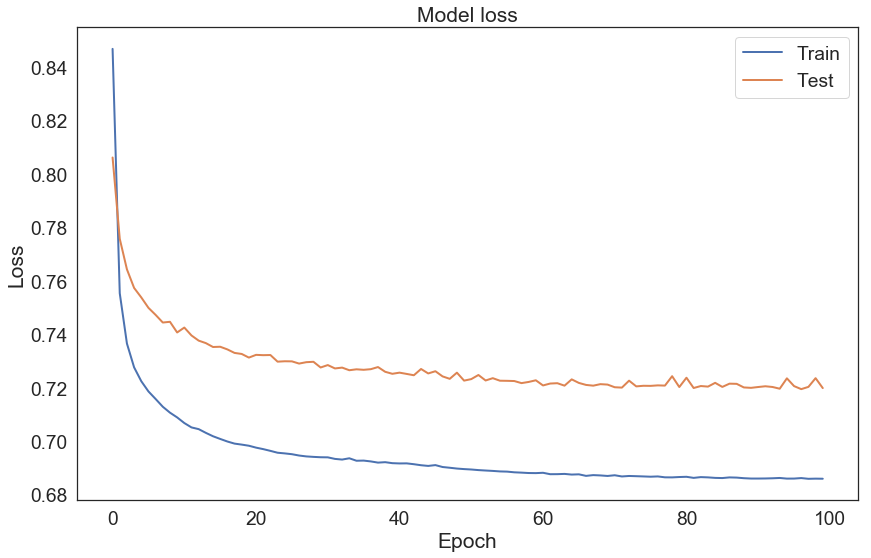

In [24]:
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

In [25]:
test_x_predictions = autoencoder.predict(test_x)
mse = np.mean(np.power(test_x - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test_y})
error_df.describe()

,Reconstruction_error,True_class
count,56962.000000,56962.000000
mean,0.719348,0.002019
std,3.109754,0.044887
min,0.045220,0.000000
25%,0.247107,0.000000
50%,0.395362,0.000000
75%,0.618276,0.000000
max,191.104409,1.000000


In [43]:
error_df.tail()

,Reconstruction_error,True_class
22627,0.378206,0
116708,1.338885,0
252381,0.290859,0
57362,0.344780,0
256271,0.807369,0


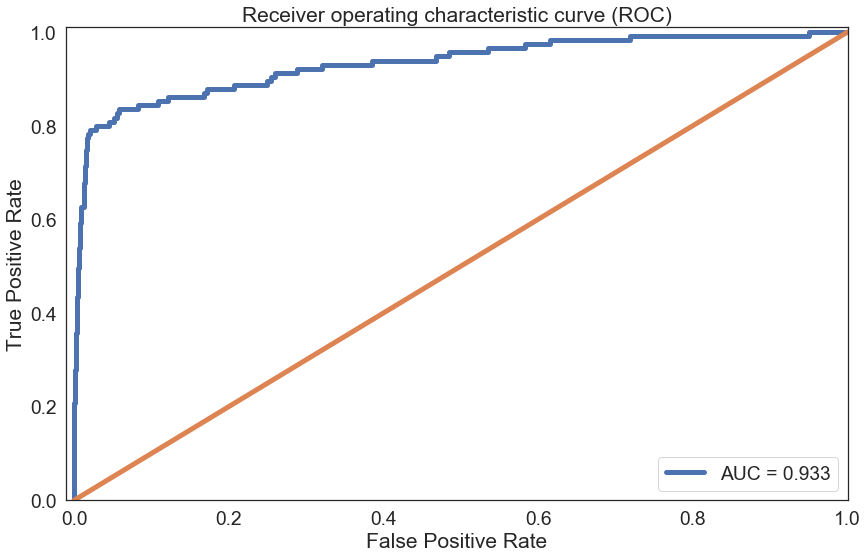

In [27]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

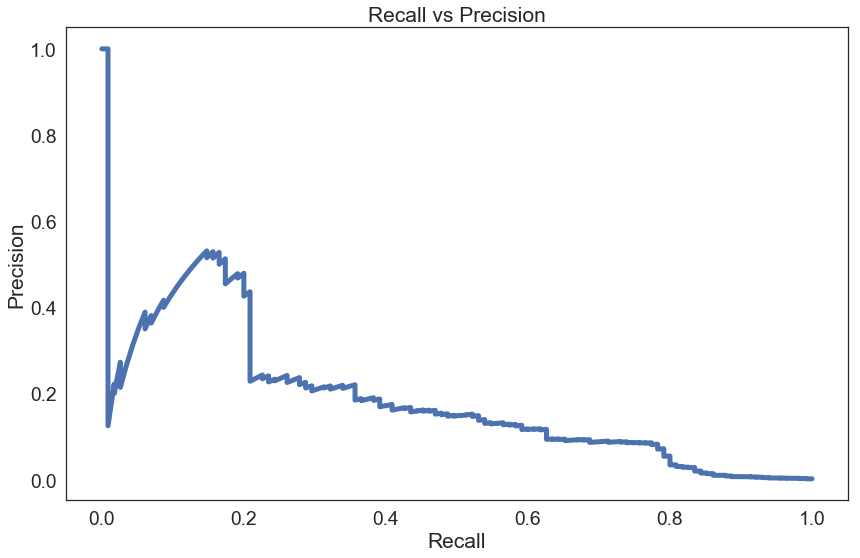

In [28]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(recall_rt, precision_rt, linewidth=5, label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

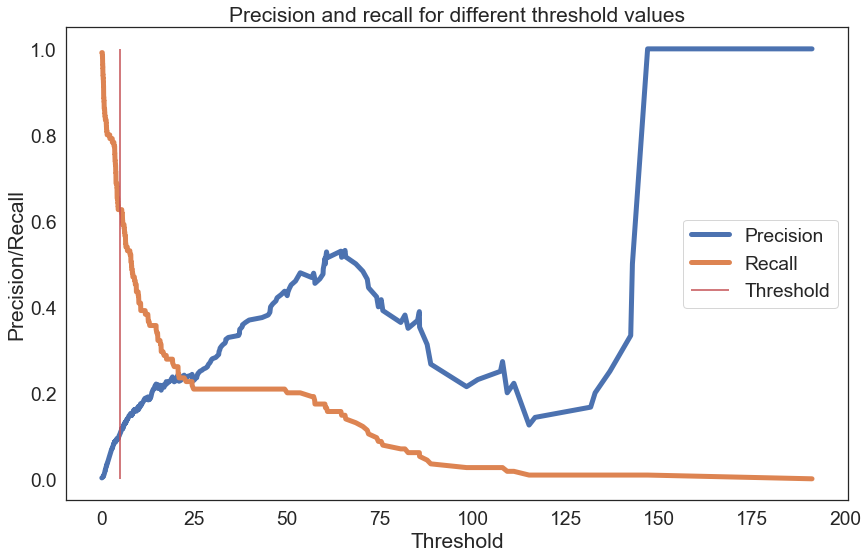

Now that we have talked with the business client and established a threshold, let's see how that compares to reconstruction error. Where the threshold is set seems to miss the main cluster of the normal transactions,but still get a lot of the fraud transactions.


In [39]:
threshold_fixed = 5
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.vlines(threshold_fixed,0,1, colors="r", zorder=100, label='Threshold')
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

print("Now that we have talked with the business client and established a threshold, \
let's see how that compares to reconstruction error. Where the threshold is set seems \
to miss the main cluster of the normal transactions,\
but still get a lot of the fraud transactions.")

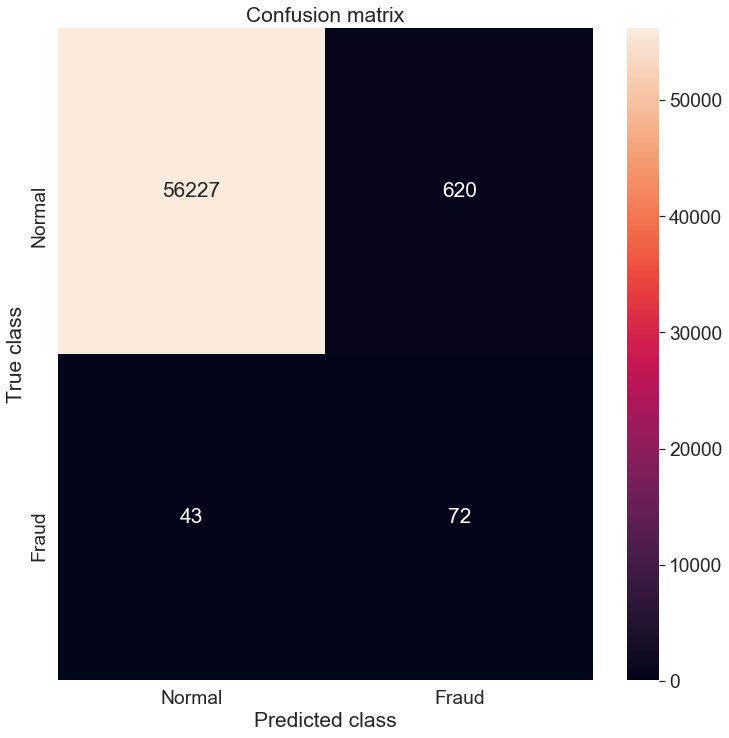

In [44]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

> You will also notice we caught about 60% of the fraud cases, which might seem low at face value but remember there are no magic bullets here. Remember two things: 1) you will never catch even close to 100% of the fraud cases in any way that is even remotely real-world useful and 2) your fraud detection algorithm will be running as a part of the overall ensemble of fraud detectors that will hopefully complement your model.

# Anomaly Reconstruction Error
 - can get significantly high

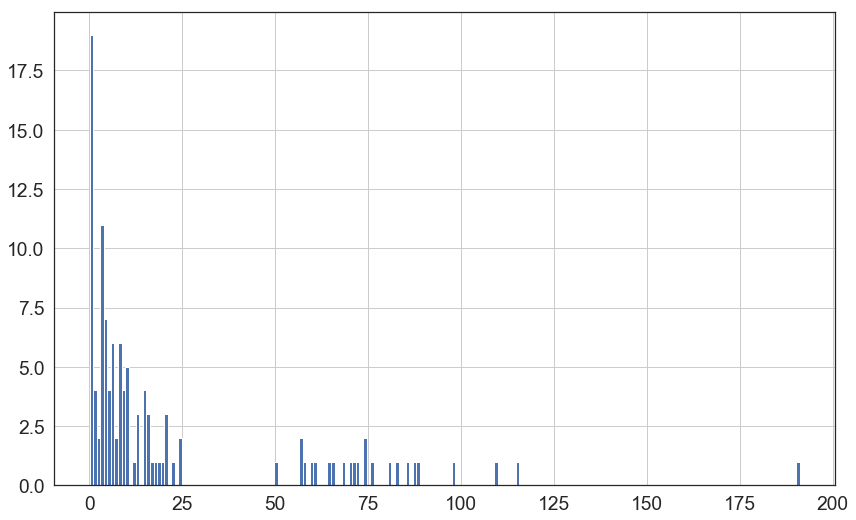

In [55]:
error_df[error_df['True_class'] == 1]['Reconstruction_error'].hist(bins = 200)

# Normal Data Reconstruction Error
 - Very Low

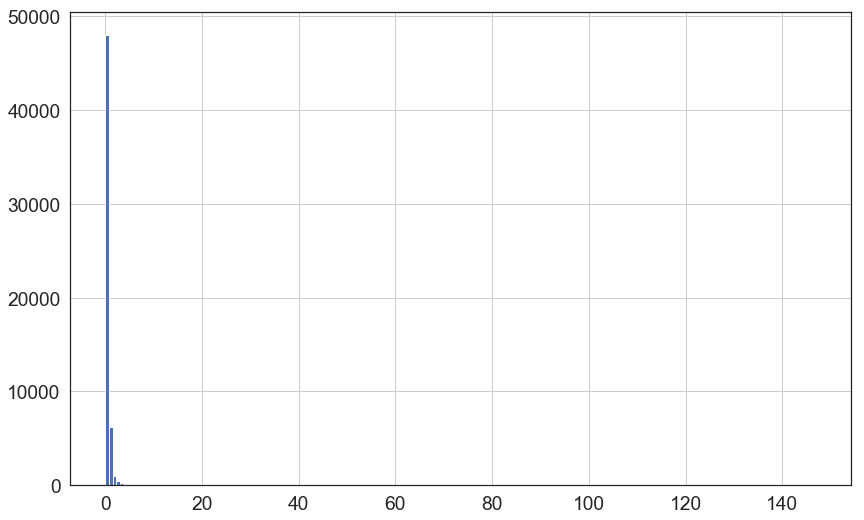

In [56]:
error_df[error_df['True_class'] == 0]['Reconstruction_error'].hist(bins = 200)

# Train on all data

In [57]:
train_x, test_x = train_test_split(df_norm, test_size=TEST_PCT, random_state=RANDOM_SEED)
#train_x = train_x[train_x.Class == 0] #where normal transactions
train_x = train_x.drop(['Class'], axis=1) #drop the class column


test_y = test_x['Class'] #save the class column for the test set
test_x = test_x.drop(['Class'], axis=1) #drop the class column

train_x = train_x.values #transform to ndarray
test_x = test_x.values

In [58]:
nb_epoch = 100
batch_size = 128
input_dim = train_x.shape[1] #num of columns, 30
encoding_dim = 14
hidden_dim = int(encoding_dim / 2) #i.e. 7
learning_rate = 1e-7

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [59]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

cp = ModelCheckpoint(filepath="autoencoder_fraud.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

history = autoencoder.fit(train_x, train_x,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(test_x, test_x),
                    verbose=1,
                    callbacks=[cp, tb]).history

Train on 227845 samples, validate on 56962 samples
Epoch 1/100
227845/227845 [==============================] - 6s 28us/step - loss: 0.8970 - acc: 0.4922 - val_loss: 0.8243 - val_acc: 0.5922
Epoch 2/100
227845/227845 [==============================] - 3s 13us/step - loss: 0.8103 - acc: 0.6273 - val_loss: 0.7834 - val_acc: 0.6471
Epoch 3/100
227845/227845 [==============================] - 4s 18us/step - loss: 0.7843 - acc: 0.6540 - val_loss: 0.7675 - val_acc: 0.6644
Epoch 4/100
227845/227845 [==============================] - 3s 15us/step - loss: 0.7721 - acc: 0.6693 - val_loss: 0.7586 - val_acc: 0.6773
Epoch 5/100
227845/227845 [==============================] - 3s 12us/step - loss: 0.7652 - acc: 0.6763 - val_loss: 0.7531 - val_acc: 0.6805
Epoch 6/100
227845/227845 [==============================] - 4s 16us/step - loss: 0.7608 - acc: 0.6788 - val_loss: 0.7499 - val_acc: 0.6815
Epoch 7/100
227845/227845 [==============================] - 4s 18us/step - loss: 0.7578 - acc: 0.6817 - val_

Epoch 59/100
227845/227845 [==============================] - 3s 12us/step - loss: 0.7352 - acc: 0.7188 - val_loss: 0.7273 - val_acc: 0.7198
Epoch 60/100
227845/227845 [==============================] - 3s 12us/step - loss: 0.7349 - acc: 0.7195 - val_loss: 0.7269 - val_acc: 0.7191
Epoch 61/100
227845/227845 [==============================] - 3s 12us/step - loss: 0.7350 - acc: 0.7183 - val_loss: 0.7284 - val_acc: 0.7174
Epoch 62/100
227845/227845 [==============================] - 3s 12us/step - loss: 0.7353 - acc: 0.7186 - val_loss: 0.7273 - val_acc: 0.7200
Epoch 63/100
227845/227845 [==============================] - 3s 12us/step - loss: 0.7348 - acc: 0.7193 - val_loss: 0.7270 - val_acc: 0.7188
Epoch 64/100
227845/227845 [==============================] - 3s 12us/step - loss: 0.7349 - acc: 0.7188 - val_loss: 0.7278 - val_acc: 0.7219
Epoch 65/100
227845/227845 [==============================] - 3s 12us/step - loss: 0.7348 - acc: 0.7184 - val_loss: 0.7269 - val_acc: 0.7176
Epoch 66/100


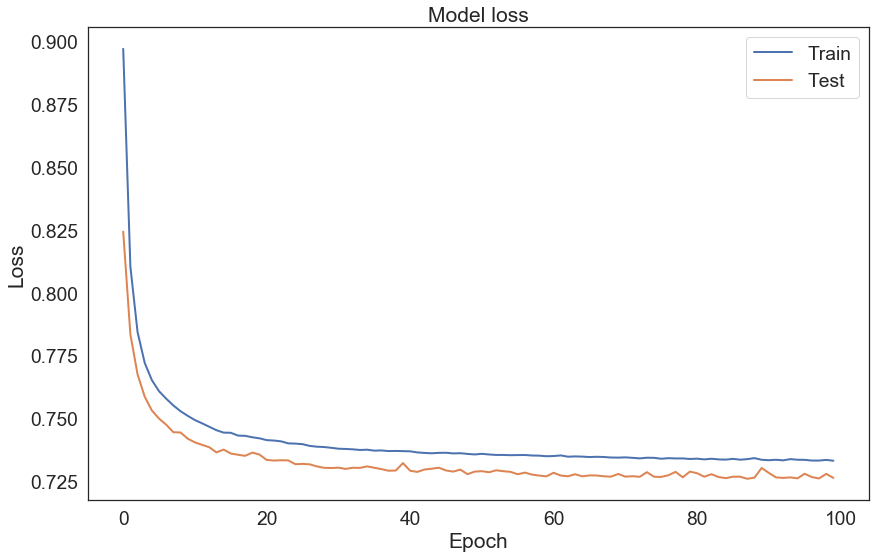

In [60]:
autoencoder = load_model('autoencoder_fraud.h5')

plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

In [61]:
test_x_predictions = autoencoder.predict(test_x)
mse = np.mean(np.power(test_x - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test_y})
error_df.describe()

,Reconstruction_error,True_class
count,56962.000000,56962.000000
mean,0.725841,0.002019
std,3.066177,0.044887
min,0.051419,0.000000
25%,0.251907,0.000000
50%,0.390675,0.000000
75%,0.621021,0.000000
max,185.308540,1.000000


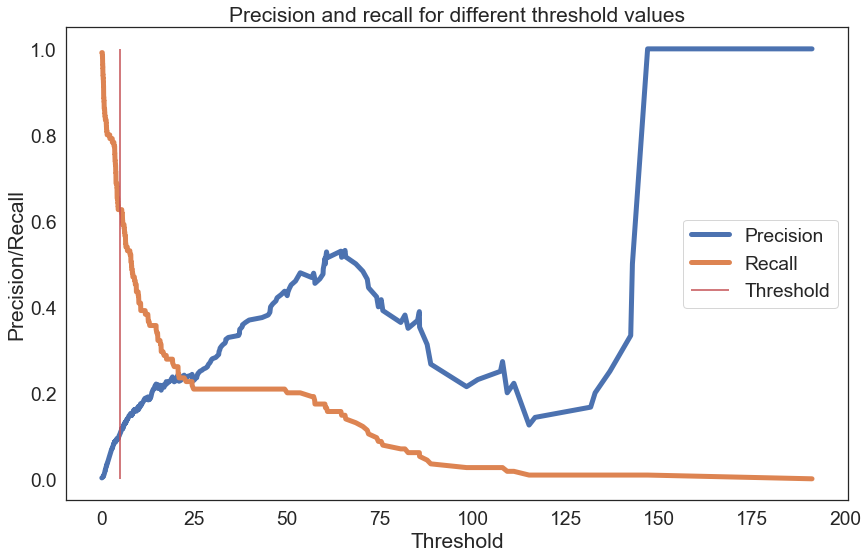

Now that we have talked with the business client and established a threshold, let's see how that compares to reconstruction error. Where the threshold is set seems to miss the main cluster of the normal transactions,but still get a lot of the fraud transactions.


In [62]:
threshold_fixed = 5
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.vlines(threshold_fixed,0,1, colors="r", zorder=100, label='Threshold')
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

print("Now that we have talked with the business client and established a threshold, \
let's see how that compares to reconstruction error. Where the threshold is set seems \
to miss the main cluster of the normal transactions,\
but still get a lot of the fraud transactions.")

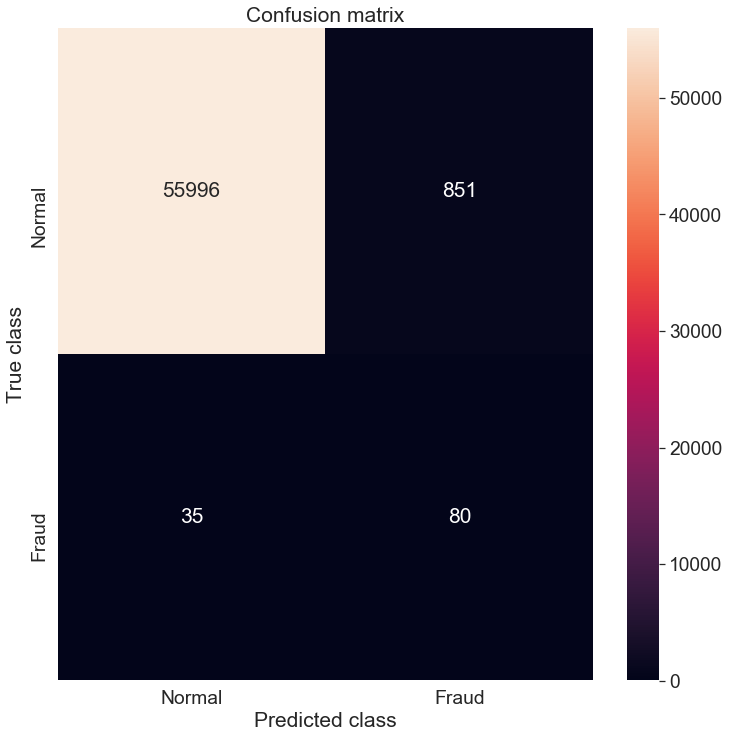

In [64]:
threshold_fixed = 4
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

# Other Keras Code

In [69]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation

nb_epoch = 100
batch_size = 128
input_dim = train_x.shape[1] #num of columns, 30
encoding_dim = 14
hidden_dim = int(encoding_dim / 2) #i.e. 7
learning_rate = 1e-7

model = Sequential()
model.add(Dense(encoding_dim, input_shape=(input_dim,)))
model.add(Activation('relu'))
model.add(Dense(input_dim))
model.add(Activation('relu'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 14)                434       
_________________________________________________________________
activation_4 (Activation)    (None, 14)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 30)                450       
_________________________________________________________________
activation_5 (Activation)    (None, 30)                0         
Total params: 884
Trainable params: 884
Non-trainable params: 0
_________________________________________________________________


In [70]:
model.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

In [71]:
cp = ModelCheckpoint(filepath="autoencoder_model_fraud.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

history = model.fit(train_x, train_x,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(test_x, test_x),
                    verbose=1,
                    callbacks=[cp, tb]).history

Train on 227845 samples, validate on 56962 samples
Epoch 1/100
227845/227845 [==============================] - 4s 15us/step - loss: 0.8472 - acc: 0.3981 - val_loss: 0.7370 - val_acc: 0.5541
Epoch 2/100
227845/227845 [==============================] - 3s 14us/step - loss: 0.7212 - acc: 0.5913 - val_loss: 0.7009 - val_acc: 0.6195
Epoch 3/100
227845/227845 [==============================] - 2s 10us/step - loss: 0.7024 - acc: 0.6284 - val_loss: 0.6931 - val_acc: 0.6385
Epoch 4/100
227845/227845 [==============================] - 2s 10us/step - loss: 0.6968 - acc: 0.6401 - val_loss: 0.6893 - val_acc: 0.6446
Epoch 5/100
227845/227845 [==============================] - 2s 11us/step - loss: 0.6935 - acc: 0.6464 - val_loss: 0.6880 - val_acc: 0.6523
Epoch 6/100
227845/227845 [==============================] - 2s 11us/step - loss: 0.6914 - acc: 0.6530 - val_loss: 0.6846 - val_acc: 0.6584
Epoch 7/100
227845/227845 [==============================] - 2s 10us/step - loss: 0.6889 - acc: 0.6563 - val_

227845/227845 [==============================] - 3s 15us/step - loss: 0.6824 - acc: 0.6688 - val_loss: 0.6769 - val_acc: 0.6708
Epoch 59/100
227845/227845 [==============================] - 3s 14us/step - loss: 0.6824 - acc: 0.6693 - val_loss: 0.6768 - val_acc: 0.6727
Epoch 60/100
227845/227845 [==============================] - 3s 12us/step - loss: 0.6824 - acc: 0.6696 - val_loss: 0.6768 - val_acc: 0.6717
Epoch 61/100
227845/227845 [==============================] - 3s 13us/step - loss: 0.6824 - acc: 0.6694 - val_loss: 0.6768 - val_acc: 0.6696
Epoch 62/100
227845/227845 [==============================] - 3s 12us/step - loss: 0.6824 - acc: 0.6695 - val_loss: 0.6782 - val_acc: 0.6702
Epoch 63/100
227845/227845 [==============================] - 3s 11us/step - loss: 0.6823 - acc: 0.6692 - val_loss: 0.6768 - val_acc: 0.6695
Epoch 64/100
227845/227845 [==============================] - 3s 13us/step - loss: 0.6823 - acc: 0.6693 - val_loss: 0.6770 - val_acc: 0.6697
Epoch 65/100
227845/227845

In [72]:
test_x_predictions = model.predict(test_x)
mse = np.mean(np.power(test_x - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test_y})
error_df.describe()

,Reconstruction_error,True_class
count,56962.000000,56962.000000
mean,0.675261,0.002019
std,2.932278,0.044887
min,0.047391,0.000000
25%,0.237502,0.000000
50%,0.373441,0.000000
75%,0.570689,0.000000
max,174.197011,1.000000


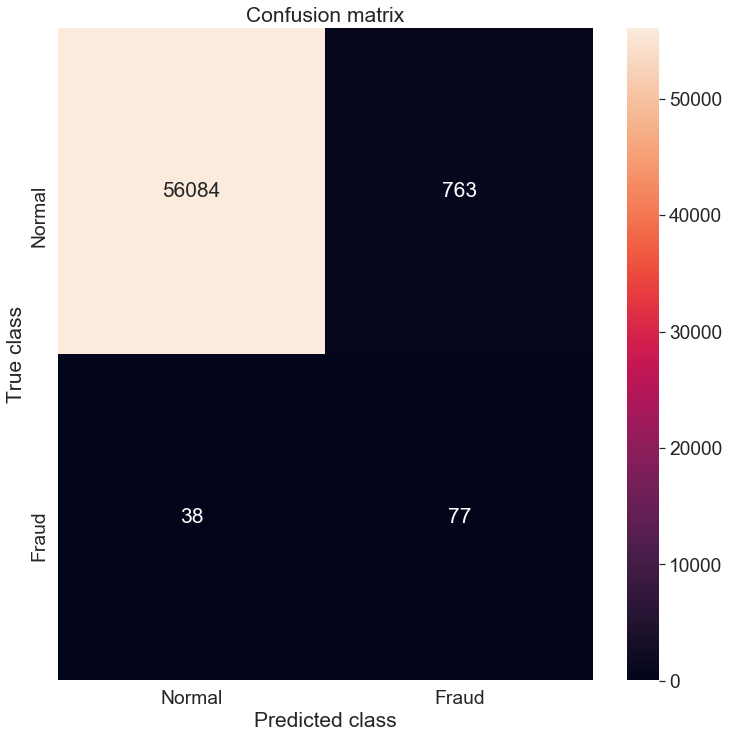

In [73]:
threshold_fixed = 4
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()